In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
from fastbook import *
from fastai.vision.widgets import *

In [8]:
def search_images_ddg(key, max_n=200):
    url = 'https://duckduckgo.com/'
    params = {'q':key}
    res = requests.post(url,data=params)
    searchObj = re.search(r'vqd=([\d-]+)\&',res.text)

    if not searchObj:
        print('Token Parsing Failed !')
        return

    requestUrl = url + 'i.js'
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0'}
    params = (('l','us-en'),('o','json'),('q',key),('vqd',searchObj.group(1)),('f',',,,'),('p','1'),('v7exp','a'))
    urls = []

    while True:
        try:
            res = requests.get(requestUrl,headers=headers,params=params)
            data = json.loads(res.text)
            for obj in data['results']:
                urls.append(obj['image'])
                max_n = max_n - 1
            if max_n < 1:
                return L(set(urls))
            if 'next' not in data:
                return L(set(urls))
            requestUrl = url + data['next']
        except:
            pass

In [9]:
scenery_types = 'mountain','forest','beach', 'concrete jungle'
path = Path('scenery')

In [11]:
if not path.exists():
    path.mkdir()
for o in scenery_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'{o}', max_n = 150)
    download_images(dest, urls=results)

In [12]:
??get_image_files

Signature: get_image_files(path, recurse=True, folders=None)
Source:   
def get_image_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=image_extensions, recurse=recurse, folders=folders)
File:      c:\programdata\anaconda3\envs\torch\lib\site-packages\fastai\data\transforms.py
Type:      function


In [13]:
??parent_label

Signature: parent_label(o)
Source:   
def parent_label(o):
    "Label `item` with the parent folder name."
    return Path(o).parent.name
File:      c:\programdata\anaconda3\envs\torch\lib\site-packages\fastai\data\transforms.py
Type:      function


In [14]:
fns = get_image_files(path)
for fn in fns:
    passed = verify_image(fn)
    if not passed:
        os.unlink(fn)

C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\PIL\Image.py:2966: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


In [25]:
scenes = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files, 
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms=Resize(128))

In [44]:
??scenes.new

Signature: scenes.new(item_tfms=None, batch_tfms=None)
Docstring: Create a new `DataBlock` with other `item_tfms` and `batch_tfms`
Source:   
    def new(self, item_tfms=None, batch_tfms=None):
        self.item_tfms  = _merge_tfms(self.default_item_tfms,  item_tfms)
        self.batch_tfms = _merge_tfms(self.default_batch_tfms, batch_tfms)
        return self
File:      c:\programdata\anaconda3\envs\torch\lib\site-packages\fastai\data\block.py
Type:      method


In [26]:
scenes = scenes.new(
    item_tfms = RandomResizedCrop(224, min_scale=0.5),
    batch_tfms = aug_transforms())
dls = scenes.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


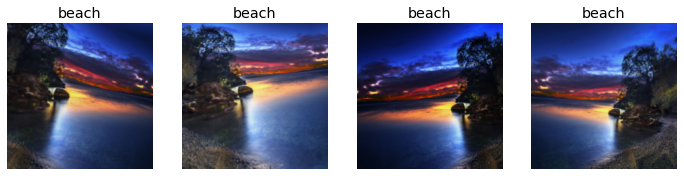

In [27]:
dls.train.show_batch(max_n = 4, nrows = 1, unique=True)

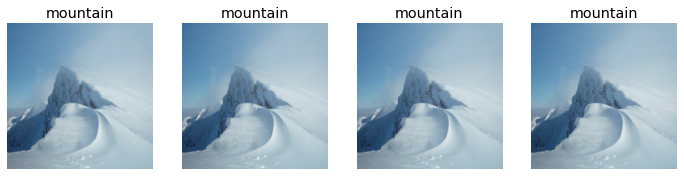

In [28]:
dls.valid.show_batch(max_n = 4, nrows = 1, unique=True)

In [38]:
learn = cnn_learner(dls, models.resnet34, metrics = error_rate)

In [40]:
??learn.fine_tune

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
)
Source:   
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `freeze` for `freeze_epochs` then with `unfreeze` from `epochs` using discriminative LR"
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      c:\programdata\anaconda3\envs\torch\lib\site-packages\fastai\callback\schedule.py
Type:      method


In [41]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.719572,0.582043,0.152672,01:03


C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.554309,0.365125,0.129771,01:02
1,0.458637,0.371540,0.114504,01:02
2,0.362155,0.365742,0.114504,01:02
3,0.300544,0.343702,0.106870,01:02


In [45]:
learn.export()

In [46]:
learn_inf = load_learner(Path()/'export.pkl')

In [47]:
learn_inf.predict('scenery/example.jpg')

('beach', tensor(0), tensor([9.9035e-01, 1.6810e-05, 1.1919e-05, 9.6237e-03]))

In [48]:
learn_inf.dls.vocab

['beach', 'concrete jungle', 'forest', 'mountain']

In [49]:
predicted, _, _ = learn_inf.predict('scenery/example.jpg')
predicted

'beach'